In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import tools
import torch
import torchsummary
import einops
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.transforms as T
from torch import nn
from torch import optim
from tqdm import tqdm

torch.manual_seed(42)

In [ ]:
#다른 모듈 업데이트를 바로 반영할 수 있도록 해주는 모듈: importlib
import importlib
importlib.reload(tools)

<module 'tools' from 'e:\\pythonStudy\\원핵공졸논\\tools.py'>

In [ ]:
root_dir = os.path.join("C:\\", "Users", "82106" ,"OneDrive - SNU" ,"23-1-youngho" ,"원자핵_졸업논문")
target_dir = "temp_macro"
target_file = "*.use"
curve_files = glob.glob(os.path.join(root_dir, target_dir, target_file))

curve_files = sorted(curve_files, key=lambda x: int(x.split('\\')[-1].split('^')[0]))
curves = []

# tools.verify_data(curve_files)

In [ ]:
curve_files[:5]

['C:\\Users\\82106\\OneDrive - SNU\\23-1-youngho\\원자핵_졸업논문\\temp_macro\\1^0.01^9^0.01^0^450.use',
 'C:\\Users\\82106\\OneDrive - SNU\\23-1-youngho\\원자핵_졸업논문\\temp_macro\\2^0.01^9^0.009^0.001^450.use',
 'C:\\Users\\82106\\OneDrive - SNU\\23-1-youngho\\원자핵_졸업논문\\temp_macro\\3^0.01^9^0.008^0.002^450.use',
 'C:\\Users\\82106\\OneDrive - SNU\\23-1-youngho\\원자핵_졸업논문\\temp_macro\\4^0.01^9^0.007^0.003^450.use',
 'C:\\Users\\82106\\OneDrive - SNU\\23-1-youngho\\원자핵_졸업논문\\temp_macro\\5^0.01^9^0.006^0.004^450.use']

파일명에서 플롯 데이터 가져오기

In [ ]:
for file in curve_files:
    curves.append(tools.get_curve(file))

파일명에서 플롯 세팅 가져오기

In [ ]:
curves_settings = []
for file in curve_files:
    curves_settings.append(tools.get_simulation_settings(file))


In [ ]:
# 대충 shape #(3305, 6)느낌
curves_settings[0] 


{'file_num': '1',
 'ks': '0.01',
 'D': '9',
 'c1': '0.01',
 'c2': '0',
 'temp': '450'}

c1 농도를 라벨로 설정하고 모델이 c1값을 맞추도록한다.

In [ ]:
target_setting = 'c1'
labels = torch.tensor([float(settings[target_setting]) for settings in curves_settings], dtype=torch.float)

In [ ]:
labels

tensor([0.0100, 0.0090, 0.0080,  ..., 0.0020, 0.0010, 0.0000])

In [ ]:
labels[:5]

tensor([0.0100, 0.0090, 0.0080, 0.0070, 0.0060])

In [ ]:
assert len(curve_files) == 3305

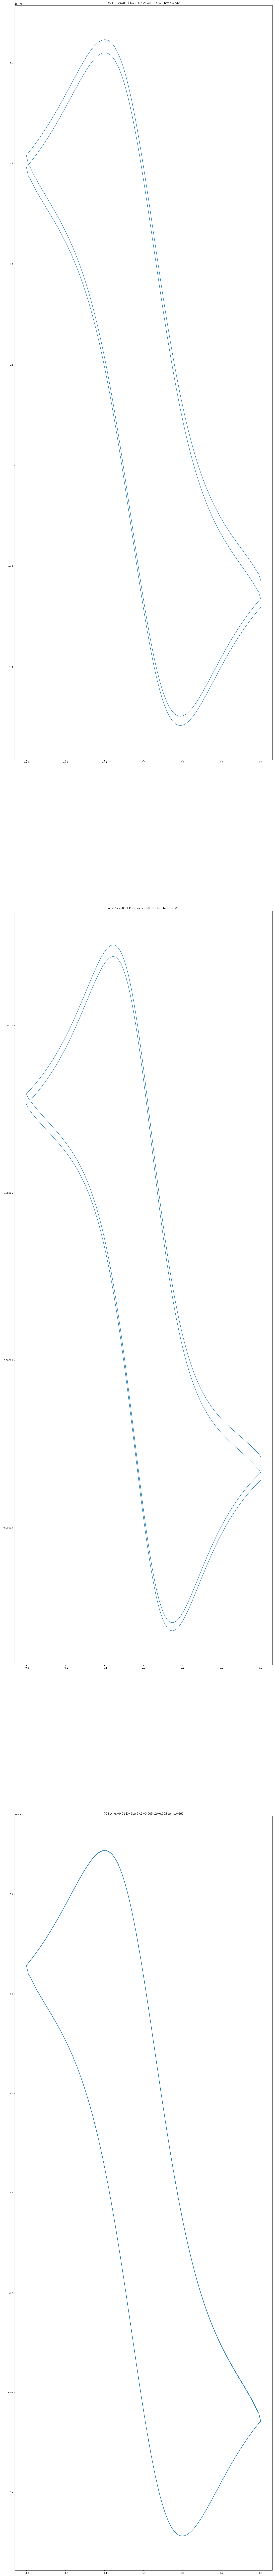

In [ ]:
curves = np.array(curves)
sample_num = 3
curve_samples_indices = np.random.choice(len(curves), size=sample_num, replace=False)
curve_samples = curves[curve_samples_indices,:, :]
curve_samples_settings = []
# curves.shape # (3305, 481, 2)

# print(curve_samples.shape)
# figure 객체 생성

def visualise_curve(sample_num, sample_curves_indices):
    fig = plt.figure(figsize=(20,200))

    # n개의 subplot 생성
    for i in range(sample_num):
        target_file = curve_files[sample_curves_indices[i]]
        file_num, ks, D, c1, c2, temp = tools.get_simulation_settings(target_file).values()
        
        ax = fig.add_subplot(sample_num, 1, i+1)
        # graphs[i]번째 그래프를 그리는 코드
        # 예시로 단순히 y = x 그래프를 그리는 코드를 작성하였습니다.
        x = curves[sample_curves_indices[i]][:, 0]
        y = curves[sample_curves_indices[i]][:, 1]
        
        ax.plot(x, y)
        ax.set_title(f"#{file_num} ks={ks} D={D}1e-6 c1={c1} c2={c2} temp.={temp}")

    # 그래프 출력
    plt.show()

visualise_curve(3, curve_samples_indices)

농도가 (0.7,0.3), (0.3,0.7)일 때와 (1,0), (0,1)일 때 비교하기

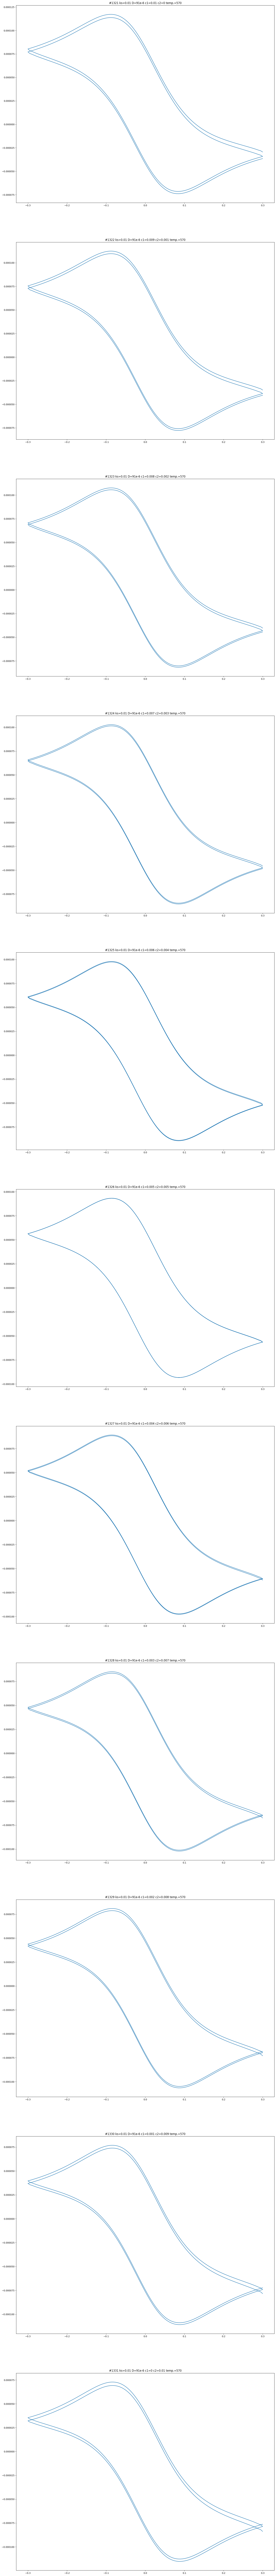

In [ ]:
visualise_curve(11, list(range(1320, 1331)))

## 먼저 데이터에서 추출할 것 정해보자.<br>
![features](features.png)<br>
### 하나의 커브마다 13개 피쳐
(s1 start I, s1_mid_I, s2_start_I, s2_mid_I,<br> s2_end_I, s1_max_I, s1_min_I, s2_max_I,<br>
s2_min_I, s1_minmax_V_diff,s2_minmax_V_diff,<br>
s1_s2_I_diff_1, s1_s2_I_diff_2 )


In [ ]:
v_max, v_min = 3e-1, -3e-1
s1_start_idx, s1_mid_idx, s2_start_idx, s2_mid_idx, s2_end_idx = 0, 120, 240, 360, 480 

In [99]:
def feature_extract_from_curve(curve=curves[0]):
    result = []

    assert curve[s1_start_idx,0] == v_max
    assert curve[s1_mid_idx,0] == v_min
    assert curve[s2_start_idx,0] == v_max
    assert curve[s2_mid_idx,0] == v_min
    assert curve[s2_end_idx,0] == v_max

    result += [curve[s1_start_idx,1], curve[s1_mid_idx,1], curve[s2_start_idx,1], curve[s2_mid_idx,1], curve[s2_end_idx,1]]
        
    s1 = curve[s1_start_idx:s2_start_idx+1, 1]
    s1_max_idx, s1_min_idx = np.argmax(s1), np.argmin(s1)
    # result += [np.abs(curve[s1_min_idx,0]-curve[s1_max_idx,0])]
    result += [s1[s1_max_idx], s1[s1_min_idx]]
    s2 = curve[s2_start_idx:, 1]
    s2_max_idx, s2_min_idx = np.argmax(s2), np.argmin(s2)
    # result += [np.abs(curve[s2_min_idx,0]-curve[s2_min_idx,0])]
    result += [s2[s2_max_idx], s2[s2_min_idx]]

    #가장 s1과 s2사이에 크게 벌어지느것의 크기
    diff_I = s1-s2
    # result += [np.max(diff_I[:s2_start_idx]), np.max(diff_I[s2_start_idx:])]
    
    return result

    

각 커브의 피처 추출 후 input에 넣기

In [100]:
input_features = []

for curve in curves:
    input_features.append(feature_extract_from_curve(curve))

input_features = np.array(input_features)


In [101]:
print(curve_files[553])
print(curve_files[557])
input_features[[553,557], :]

C:\Users\82106\OneDrive - SNU\23-1-youngho\원자핵_졸업논문\temp_macro\554^0.01^9^0.007^0.003^500.use
C:\Users\82106\OneDrive - SNU\23-1-youngho\원자핵_졸업논문\temp_macro\558^0.01^9^0.003^0.007^500.use


array([[ 1.0975144e-04, -9.1609809e-05,  1.0842910e-04, -9.2555517e-05],
       [ 9.0546152e-05, -1.0909969e-04,  9.2082785e-05, -1.0806514e-04]])

In [102]:
# 원본

def normalize(x):
    mean = x.mean()
    std = x.std()
    return (x - mean) / std

class Custom_Dataset(Dataset):
    def __init__(self, input_features, labels, transform=None):
        self.input_feature = input_features
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.input_feature)
    
    def __getitem__(self, idx):
        if self.transform:
            # print(idx)
            return torch.tensor(self.transform(input_features[idx]), dtype=torch.float32), labels[idx]
        return torch.tensor(input[idx]), labels[idx]

simul_dataset = Custom_Dataset(input_features, labels, transform=normalize)

# normalized input_feature and its label
# simul_dataset.__getitem__(1)

#dataset을 train, val, test로 나눠주기
N = len(simul_dataset)
indices = list(range(N))
np.random.shuffle(indices)

train_size = int(N*0.8)
val_size = (N - train_size) // 2
test_size = N-train_size-val_size

train_indices, val_indices, test_indices = indices[:train_size], indices[train_size:train_size+val_size], indices[-test_size:]
assert len(test_indices) == test_size
assert len(val_indices) == val_size
assert len(test_indices) == test_size

train_dataset = Subset(simul_dataset, train_indices)
val_dataset = Subset(simul_dataset, val_indices)
test_dataset = Subset(simul_dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

In [103]:
# #with multiplier 

# def normalize(x):
#     mean = x.mean()
#     std = x.std()
#     return (x - mean) / std

# class Custom_Dataset(Dataset):
#     def __init__(self, input_features, labels, transform=None):
#         self.input_feature = input_features
#         self.labels = labels
#         self.transform = transform

#     def __len__(self):
#         return len(self.input_feature)
    
#     def __getitem__(self, idx):
#         if self.transform:
#             # print(idx)
#             feature_multipiler = 1e6
#             label_multiplier = 1e3
#             return torch.tensor((input_features[idx]*feature_multipiler), dtype=torch.float32), labels[idx]*label_multiplier
#         return torch.tensor(input[idx]), labels[idx]

# simul_dataset = Custom_Dataset(input_features, labels, transform=normalize)

# # normalized input_feature and its label
# # simul_dataset.__getitem__(1)

# #dataset을 train, val, test로 나눠주기
# N = len(simul_dataset)
# indices = list(range(N))
# np.random.shuffle(indices)

# train_size = int(N*0.8)
# val_size = (N - train_size) // 2
# test_size = N-train_size-val_size

# train_indices, val_indices, test_indices = indices[:train_size], indices[train_size:train_size+val_size], indices[-test_size:]
# assert len(test_indices) == test_size
# assert len(val_indices) == val_size
# assert len(test_indices) == test_size

# train_dataset = Subset(simul_dataset, train_indices)
# val_dataset = Subset(simul_dataset, val_indices)
# test_dataset = Subset(simul_dataset, test_indices)

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

In [104]:
# new dataset 확인
train_dataset.__getitem__(0)

(tensor([ 0.9995, -1.0002,  1.0005, -0.9998]), tensor(0.0050))

In [113]:
num_input_features = 4

class Simple_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(num_input_features, 512)
        self.linear2 = nn.Linear(512, 1024)
        self.linear3 = nn.Linear(1024, 1)
        self.gelu = nn.GELU()

    def forward(self, x):
        x = self.gelu(self.linear1(x))
        x = self.gelu(self.linear2(x))
        x = self.gelu(self.linear3(x))

        return x
    
simple_model = Simple_Model()

하이퍼파라미터 설정해주기

In [ ]:
learning_rate = 1e-5
num_epoch = 1000
batch_size = 64

device = 'cuda' if torch.cuda.is_available() else 'cpu'

criterion = nn.MSELoss()
optimizer = optim.Adam(simple_model.parameters(), lr=learning_rate)

In [ ]:
epoch_train_loss, epoch_val_loss = [], []

In [ ]:
def trainer(model, criterion, optimizer, num_epoch):
    model.to(device)

    running_loss, running_acc = {}, {}
    global_val_loss = 1e100

    for epoch in range(num_epoch):
        print(f"Epoch {epoch+1}/{num_epoch}")
        print("-"*10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss[phase], running_acc[phase] = 0.0, 0.0

            for inputs, labels in tqdm(dataloaders[phase], total=len(dataloaders[phase]),  ncols=70, ascii=' =', leave=True):
                inputs = inputs.to(device)
                labels = labels.to(device)

                #zero the parameter gradients 
                optimizer.zero_grad()

                #forward in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss[phase] += loss.item() * inputs.shape[0]
                
            running_loss[phase] = running_loss[phase] / len(dataloaders[phase])
            

            if phase == 'train':
                epoch_train_loss.append(running_loss[phase])
            else:
                epoch_val_loss.append(running_loss[phase])

            
        if running_loss['val'] < global_val_loss:
            global_val_loss = running_loss[phase]
            torch.save({"model": model.state_dict(), "optimizer": optimizer.state_dict()}, f"best_model.pth")                       
        
        print(f"validation loss {running_loss[phase]}")


In [118]:
trainer(simple_model, criterion, optimizer, num_epoch)

Epoch 1/100
----------


100%|==================================| 6/6 [00:00<00:00, 103.72it/s]


validation loss 0.0005529323234441108
Epoch 2/100
----------


100%|==================================| 6/6 [00:00<00:00, 117.96it/s]


validation loss 0.0005750976933995844
Epoch 3/100
----------


100%|==================================| 6/6 [00:00<00:00, 101.97it/s]


validation loss 0.0005634038431405012
Epoch 4/100
----------


100%|===================================| 6/6 [00:00<00:00, 95.49it/s]


validation loss 0.0005711737800690267
Epoch 5/100
----------


100%|===================================| 6/6 [00:00<00:00, 91.15it/s]


validation loss 0.0005565187217750159
Epoch 6/100
----------


 83%|===========================      | 35/42 [00:00<00:00, 47.94it/s]


KeyboardInterrupt: 

Text(0, 0.5, 'val loss')

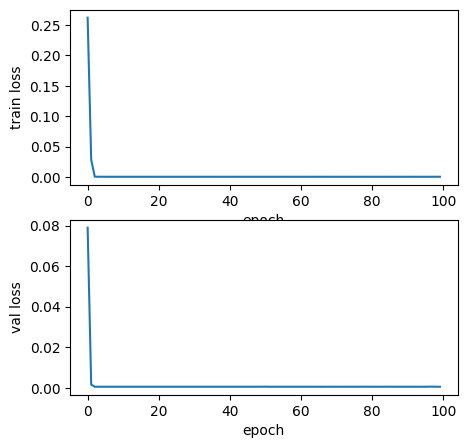

In [110]:
# train loss랑 val loss 그래프 그려보기
fig = plt.figure(figsize=(5,5))

ax1 = fig.add_subplot(2, 1, 1)
x = list(range(len(epoch_train_loss)))
y = epoch_train_loss

ax1.plot(x, y)
ax1.set_xlabel('epoch')
ax1.set_ylabel('train loss')

ax2 = fig.add_subplot(2, 1, 2)
x = list(range(len(epoch_val_loss)))
y = epoch_val_loss

ax2.plot(x, y)
ax2.set_xlabel('epoch')
ax2.set_ylabel('val loss')

# plt.show()
#  # n개의 subplot 생성
#     for i in range(sample_num):
#         target_file = curve_files[sample_curves_indices[i]]
#         file_num, ks, D, c1, c2, temp = tools.get_simulation_settings(target_file).values()
        
#         ax = fig.add_subplot(sample_num, 1, i+1)
#         # graphs[i]번째 그래프를 그리는 코드
#         # 예시로 단순히 y = x 그래프를 그리는 코드를 작성하였습니다.
#         x = curves[sample_curves_indices[i]][:, 0]
#         y = curves[sample_curves_indices[i]][:, 1]
        
#         ax.plot(x, y)
#         ax.set_title(f"#{file_num} ks={ks} D={D}1e-6 c1={c1} c2={c2} temp.={temp}")

#     # 그래프 출력
#     plt.show()

결과 확인하기

In [112]:
best_model_path = 'best_model.pth'
model_state_dict = torch.load(best_model_path)['model']
# print(model_state_dict)
simple_model.load_state_dict(model_state_dict)
test_phase = 'test'

# # print(len(dataloaders[test_phase])) # 331
simple_model.eval()
for inputs, input_labels in tqdm(dataloaders[test_phase], total=len(dataloaders[test_phase]),  ncols=70, ascii=' =', leave=True):
    with torch.no_grad():
        # print(inputs)
        x = simple_model(inputs)
        y = input_labels

        print(x, y)

 35%|==========                    | 115/331 [00:00<00:00, 567.83it/s]

tensor([[0.0048]]) tensor([0.])
tensor([[0.0052]]) tensor([0.0060])
tensor([[0.0052]]) tensor([0.0060])
tensor([[0.0051]]) tensor([0.0040])
tensor([[0.0053]]) tensor([0.0060])
tensor([[0.0051]]) tensor([0.0040])
tensor([[0.0053]]) tensor([0.0070])
tensor([[0.0049]]) tensor([0.0010])
tensor([[0.0050]]) tensor([0.0020])
tensor([[0.0049]]) tensor([0.0010])
tensor([[0.0053]]) tensor([0.0070])
tensor([[0.0053]]) tensor([0.0070])
tensor([[0.0052]]) tensor([0.0050])
tensor([[0.0053]]) tensor([0.0060])
tensor([[0.0051]]) tensor([0.0030])
tensor([[0.0053]]) tensor([0.0080])
tensor([[0.0052]]) tensor([0.0060])
tensor([[0.0048]]) tensor([0.])
tensor([[0.0049]]) tensor([0.0010])
tensor([[0.0051]]) tensor([0.0030])
tensor([[0.0048]]) tensor([0.])
tensor([[0.0049]]) tensor([0.0010])
tensor([[0.0052]]) tensor([0.0060])
tensor([[0.0054]]) tensor([0.0080])
tensor([[0.0050]]) tensor([0.0020])
tensor([[0.0053]]) tensor([0.0070])
tensor([[0.0049]]) tensor([0.0010])
tensor([[0.0054]]) tensor([0.0090])
tens

 69%|====================          | 230/331 [00:00<00:00, 547.38it/s]

tensor([[0.0053]]) tensor([0.0060])
tensor([[0.0052]]) tensor([0.0060])
tensor([[0.0054]]) tensor([0.0090])
tensor([[0.0054]]) tensor([0.0090])
tensor([[0.0050]]) tensor([0.0020])
tensor([[0.0051]]) tensor([0.0040])
tensor([[0.0052]]) tensor([0.0060])
tensor([[0.0052]]) tensor([0.0060])
tensor([[0.0053]]) tensor([0.0070])
tensor([[0.0051]]) tensor([0.0040])
tensor([[0.0049]]) tensor([0.])
tensor([[0.0054]]) tensor([0.0100])
tensor([[0.0053]]) tensor([0.0070])
tensor([[0.0049]]) tensor([0.0010])
tensor([[0.0049]]) tensor([0.0010])
tensor([[0.0054]]) tensor([0.0090])
tensor([[0.0055]]) tensor([0.0100])
tensor([[0.0052]]) tensor([0.0050])
tensor([[0.0052]]) tensor([0.0050])
tensor([[0.0054]]) tensor([0.0080])
tensor([[0.0051]]) tensor([0.0040])
tensor([[0.0050]]) tensor([0.0030])
tensor([[0.0052]]) tensor([0.0050])
tensor([[0.0055]]) tensor([0.0100])
tensor([[0.0049]]) tensor([0.])
tensor([[0.0054]]) tensor([0.0100])
tensor([[0.0048]]) tensor([0.])
tensor([[0.0052]]) tensor([0.0060])
tens

100%|==============================| 331/331 [00:00<00:00, 551.31it/s]

tensor([[0.0051]]) tensor([0.0030])
tensor([[0.0052]]) tensor([0.0060])
tensor([[0.0051]]) tensor([0.0030])
tensor([[0.0048]]) tensor([0.])
tensor([[0.0053]]) tensor([0.0070])
tensor([[0.0053]]) tensor([0.0070])
tensor([[0.0053]]) tensor([0.0060])
tensor([[0.0049]]) tensor([0.0010])
tensor([[0.0054]]) tensor([0.0080])
tensor([[0.0052]]) tensor([0.0060])
tensor([[0.0049]]) tensor([0.0010])
tensor([[0.0054]]) tensor([0.0090])
tensor([[0.0053]]) tensor([0.0070])
tensor([[0.0054]]) tensor([0.0090])
tensor([[0.0051]]) tensor([0.0030])
tensor([[0.0052]]) tensor([0.0050])
tensor([[0.0055]]) tensor([0.0100])
tensor([[0.0053]]) tensor([0.0070])
tensor([[0.0051]]) tensor([0.0030])
tensor([[0.0054]]) tensor([0.0080])
tensor([[0.0052]]) tensor([0.0050])
tensor([[0.0055]]) tensor([0.0100])
tensor([[0.0051]]) tensor([0.0040])
tensor([[0.0054]]) tensor([0.0080])
tensor([[0.0049]]) tensor([0.0010])
tensor([[0.0049]]) tensor([0.0010])
tensor([[0.0049]]) tensor([0.])
tensor([[0.0051]]) tensor([0.0040])


In [34]:
input_features[1390]

array([-5.1241447e-05,  6.1118022e-05, -5.2019744e-05,  6.0554691e-05,
       -5.2445040e-05,  1.7000000e-01,  9.7414466e-05, -8.8444827e-05,
        0.0000000e+00,  9.6808224e-05, -8.8894238e-05,  7.7829700e-07,
        4.2529600e-07])